In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox 
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot
import warnings

In [42]:
df = pd.read_csv('zillow_data.csv')
df_income = pd.read_csv('zip_codes_2019_median_inc.csv')

In [43]:
df.columns = df.columns.str.strip().str.lower()
df_income.columns = df_income.columns.str.strip().str.lower()

In [44]:
df.rename(columns={'regionname': 'zipcode', 'countyname':'county'},inplace=True)
df_income.rename(columns={
    'zip code':'zipcode', 'population (2019)': 'population',
    'median family income (2019)': 'median_family_income'},
                 inplace=True)


In [45]:
df = df[df['state']=='TX']
df_income['state'] = df_income['preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['type'] != 'PO box'])

In [46]:
df_income.head()


,zipcode,type,state fips,preferred name,alternate names,population,housing units (2019),median_family_income,mfi percentile (2019),latitude,longitude,land area,water area,state
31142,73301,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31143,73344,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31744,75001,standard,48,"Addison, TX",NaN,"14,992","9,298","$79,551",68.0,32.959999,-96.838997,3.834,0.003,TX
31745,75002,standard,48,"Allen, TX","Lucas, Parker","71,253","23,314","$105,656",88.0,33.090000,-96.609001,37.179,2.056,TX
31746,75006,standard,48,"Carrollton, TX",NaN,"51,642","19,178","$72,325",57.0,32.962002,-96.899002,16.875,0.254,TX


In [47]:
#Calculate historical return on investment
df['ROI']= (df['2018-04']/df['1996-04'])-1
df['ROI']


#Calculate standard deviation of monthly values
df['std']=df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean']=df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
df['CV']=df['std']/df['mean']

#Show calculated values
df[['zipcode','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(df.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = df[df['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV']]

warnings.filterwarnings

count    989.000000
mean       0.167433
std        0.041415
min        0.045182
25%        0.142279
50%        0.165783
75%        0.189448
max        0.361446
Name: CV, dtype: float64

CV upper limit: 0.17479440936725246

 Best 5 Zipcodes:


<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

In [48]:
df.drop(['regionid', 'sizerank', 'metro'], axis=1,inplace=True)

In [49]:
df_income = df_income[df_income.columns[np.r_[0,5,7,9:11]]]
df_income


,zipcode,population,median_family_income,latitude,longitude
31142,73301,NaN,NaN,NaN,NaN
31143,73344,NaN,NaN,NaN,NaN
31744,75001,"14,992","$79,551",32.959999,-96.838997
31745,75002,"71,253","$105,656",33.090000,-96.609001
31746,75006,"51,642","$72,325",32.962002,-96.899002
...,...,...,...,...,...
34257,79961,NaN,NaN,NaN,NaN
34258,79968,NaN,NaN,NaN,NaN
34259,79976,NaN,NaN,NaN,NaN
34260,79978,NaN,NaN,NaN,NaN


In [50]:
# fixing mfi and pop columns
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)
df_income['population'] = df_income['population'].str.replace(',','')
df_income['population'] = df_income['population'].astype(int)

<ipython-input-50-07f5f36c8a35>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income['median_family_income'] = df_income['median_family_income'].astype(int)
<ipython-input-50-07f5f36c8a35>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income['population'] = df_income['population'].str.replace(',','')
<ipython-input-50-07f5f36c8a35>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [51]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['zipcode', 'City', 'CountyName','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [52]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   zipcode     255096 non-null  int64         
 1   City        255096 non-null  object        
 2   CountyName  255096 non-null  object        
 3   ROI         250160 non-null  float64       
 4   std         255096 non-null  float64       
 5   mean        255096 non-null  float64       
 6   CV          255096 non-null  float64       
 7   date        255096 non-null  datetime64[ns]
 8   value       255096 non-null  float64       
 9   year        255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 21.4+ MB


In [53]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,City,CountyName,ROI,std,mean,CV,value,year
date,,,,,,,,,
1996-04-01,75070,McKinney,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [54]:
df_merged = df.reset_index().merge(df_income, how='left').set_index('date')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255096 entries, 1996-04-01 to 2018-04-01
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   zipcode               255096 non-null  int64  
 1   City                  255096 non-null  object 
 2   CountyName            255096 non-null  object 
 3   ROI                   250160 non-null  float64
 4   std                   255096 non-null  float64
 5   mean                  255096 non-null  float64
 6   CV                    255096 non-null  float64
 7   value                 255096 non-null  float64
 8   year                  255096 non-null  int64  
 9   population            252181 non-null  float64
 10  median_family_income  252181 non-null  float64
 11  latitude              252181 non-null  float64
 12  longitude             252181 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 27.2+ MB


In [55]:
df_merged.describe().T


,count,mean,std,min,25%,50%,75%,max
zipcode,255096.0,77163.777546,1361.342308,75001.000000,76017.000000,77098.000000,78251.000000,7.993800e+04
ROI,250160.0,0.940549,0.418125,-0.375469,0.721048,0.903395,1.101759,6.550360e+00
std,255096.0,23762.532113,16134.709292,2684.773009,13998.832825,19663.932774,29134.083926,1.437548e+05
mean,255096.0,140540.600793,94822.092356,32718.292683,81482.641509,115224.150943,165333.207547,8.802596e+05
CV,255096.0,0.168955,0.040480,0.045182,0.144163,0.166917,0.189818,3.614458e-01
value,255096.0,140540.600793,99061.016727,24100.000000,79900.000000,113700.000000,165100.000000,1.268600e+06
year,255096.0,2006.908003,6.393508,1996.000000,2001.000000,2007.000000,2012.000000,2.018000e+03
population,252181.0,25939.370892,20385.536014,1056.000000,9761.000000,21879.000000,37281.000000,1.282940e+05
median_family_income,252181.0,77689.448301,32642.262099,21169.000000,56108.000000,69722.000000,90867.000000,2.500010e+05
latitude,252181.0,31.108154,1.797547,25.944000,29.736000,30.805000,32.723999,3.604600e+01


In [56]:
df_merged_upper_pop = df_merged['population'].quantile(.75)
df_filtered = df_merged[(df_merged['population'] > df_merged_upper_pop)]

In [57]:
# Select the first quantile
q1 = df_filtered['value'].quantile(.25)

# Select the third quantile
q3 = df_filtered['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered = df_filtered[(df_filtered['value']>=q1) 
             & (df_filtered['value']<=q3)]
df_filtered = pd.DataFrame(filtered)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31421 entries, 1996-04-01 to 2018-04-01
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               31421 non-null  int64  
 1   City                  31421 non-null  object 
 2   CountyName            31421 non-null  object 
 3   ROI                   31421 non-null  float64
 4   std                   31421 non-null  float64
 5   mean                  31421 non-null  float64
 6   CV                    31421 non-null  float64
 7   value                 31421 non-null  float64
 8   year                  31421 non-null  int64  
 9   population            31421 non-null  float64
 10  median_family_income  31421 non-null  float64
 11  latitude              31421 non-null  float64
 12  longitude             31421 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 3.4+ MB


In [58]:
# group by date and aggregate on median value
df_filtered['median_house_price'] = df_filtered.groupby('date').aggregate({'value':'median'})
df_filtered['affordability'] = df_filtered['value'] - df_filtered['median_family_income']/.12

In [59]:
# create function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_filtered['affordability_score']  = normalize_data(df_filtered['affordability'])
df_filtered

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,
1996-04-01,78660,Pflugerville,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,124500.0,-692208.333333,0.409033
1996-04-01,77573,League City,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,124500.0,-874791.666667,0.221835
1996-04-01,77584,Pearland,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,124500.0,-912691.666667,0.182977
1996-04-01,79912,El Paso,El Paso,0.571429,26245.575483,154012.075472,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,124500.0,-523183.333333,0.582329
1996-04-01,78130,New Braunfels,Comal,0.784504,23349.861603,153368.301887,0.152247,123900.0,1996,77400.0,76824.0,29.694000,-98.072998,124500.0,-516300.000000,0.589387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78552,Harlingen,Cameron,0.468835,9181.535729,85940.377358,0.106836,108400.0,2018,37948.0,52891.0,26.194000,-97.750999,144750.0,-332358.333333,0.777977
2018-04-01,77014,Houston,Harris,0.619588,15782.797130,122692.452830,0.128637,157100.0,2018,37488.0,55613.0,29.981001,-95.463997,144750.0,-306341.666667,0.804651
2018-04-01,77506,Pasadena,Harris,1.255187,12538.003841,69982.264151,0.179160,108700.0,2018,38765.0,46462.0,29.714001,-95.199997,144750.0,-278483.333333,0.833214


In [60]:
# filtering to the 20th percentile
top_20 = df_filtered['affordability_score'].quantile(.5)
top_20

0.5827053536337383

In [61]:
df_filtered_20 = df_filtered[(df_filtered['affordability_score'] < top_20)]

In [62]:
df_filtered_20.reset_index().isna().sum()

date                    0
zipcode                 0
City                    0
CountyName              0
ROI                     0
std                     0
mean                    0
CV                      0
value                   0
year                    0
population              0
median_family_income    0
latitude                0
longitude               0
median_house_price      0
affordability           0
affordability_score     0
dtype: int64

In [63]:
df_filtered_20 = df_filtered_20['2017-01-01':].dropna()

In [64]:
df_filtered_20 = df_filtered_20.reset_index()
df_filtered_20 = df_filtered_20.loc[df_filtered_20.groupby("zipcode")["ROI"].idxmax()].sort_values('ROI',axis=0,ascending=False)[:5]
df_filtered_20.set_index('date',inplace=True)
df_filtered_20

,zipcode,City,CountyName,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,
2017-01-01,79423,Lubbock,Lubbock,1.082037,21451.329003,105156.226415,0.203995,139000.0,2017,40303.0,82989.0,33.439999,-101.855003,145050.0,-552575.000000,0.552195
2017-01-01,77571,La Porte,Harris,1.040936,20507.800452,116197.358491,0.176491,153100.0,2017,37427.0,85150.0,29.688000,-95.056999,145050.0,-556483.333333,0.548188
2017-01-01,76108,Fort Worth,Tarrant,1.013480,17152.126989,106005.660377,0.161804,143500.0,2017,43169.0,80040.0,32.787998,-97.524002,145050.0,-523500.000000,0.582005
2017-01-01,75052,Grand Prairie,Dallas,0.995040,19370.586349,134230.188679,0.144309,176200.0,2017,95495.0,85220.0,32.665001,-97.025002,145050.0,-533966.666667,0.571274
2017-01-01,75104,Cedar Hill,Dallas,0.954222,18302.905606,129367.924528,0.141479,166100.0,2017,49171.0,83143.0,32.580002,-96.964996,145050.0,-526758.333333,0.578664


In [65]:
zipcodes = list(df_filtered_20['zipcode'].values)

In [66]:
df_filtered_20 = df_filtered_20[df_filtered_20['zipcode'].isin(zipcodes)]

In [67]:
df_merged = df_merged[df_merged['zipcode'].isin(zipcodes)]

In [68]:
df_merged['zipcode'].value_counts()

77571    265
79423    265
75104    265
75052    265
76108    265
Name: zipcode, dtype: int64

In [69]:
df_prices = pd.DataFrame(df_merged[['zipcode', 'value']], index = df_merged.index)
df_prices.reset_index(inplace=True)

In [70]:
df_p = df_prices.pivot("date", "zipcode", "value")
df_p

zipcode,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,100800.0,98300.0,81600.0,85500.0,70700.0
1996-05-01,100900.0,98500.0,81500.0,85600.0,70900.0
1996-06-01,101000.0,98700.0,81400.0,85800.0,71200.0
1996-07-01,101000.0,99000.0,81400.0,85900.0,71500.0
1996-08-01,101200.0,99200.0,81400.0,86000.0,71800.0
...,...,...,...,...,...
2017-12-01,194300.0,184400.0,158300.0,170300.0,147900.0
2018-01-01,195200.0,187000.0,160100.0,171800.0,148200.0
2018-02-01,196700.0,189100.0,161900.0,173100.0,148200.0


In [73]:
df_p.columns

Int64Index([75052, 75104, 76108, 77571, 79423], dtype='int64', name='zipcode')

# 77571

In [222]:
df_77571 = pd.DataFrame(df_p[77571][df_p[77571].notnull()]).astype(int) 
df_77571['value'] = df_77571[77571] 
df_77571.drop(df_77571.columns[np.r_[1]], axis=1, inplace=True)

In [223]:
df_77571

,77571
date,
1996-04-01,85500
1996-05-01,85600
1996-06-01,85800
1996-07-01,85900
1996-08-01,86000
...,...
2017-12-01,170300
2018-01-01,171800
2018-02-01,173100


<AxesSubplot:xlabel='date'>

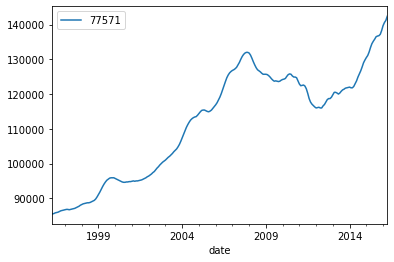

In [224]:
train = df_77571[:-24]
test = df_77571[-241:]
train.plot()

<AxesSubplot:xlabel='date'>

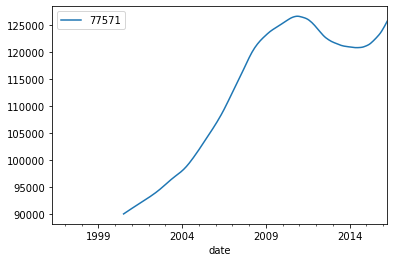

In [225]:
# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

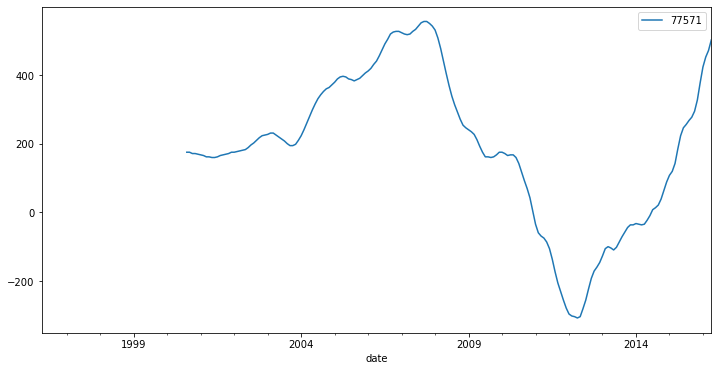

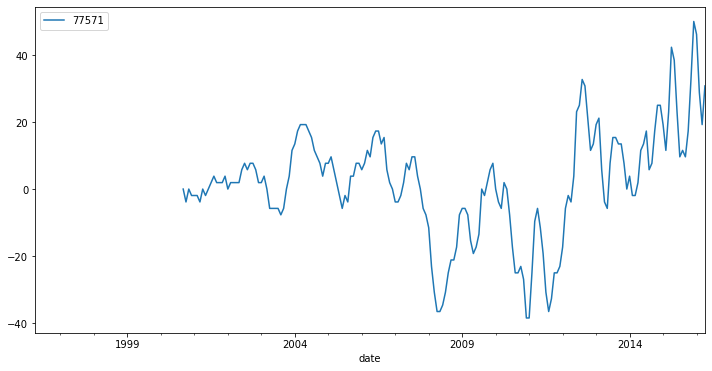

In [226]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))

In [227]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

Results of Dickey-Fuller Test: 

Test Statistic                   0.511947
p-value                          0.985232
#Lags Used                       5.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -2.400236
p-value                          0.141670
#Lags Used                       4.000000
Number of Observations Used    183.000000
Critical Value (1%)             -3.466598
Critical Value (5%)             -2.877467
Critical Value (10%)            -2.575260
dtype: float64
None


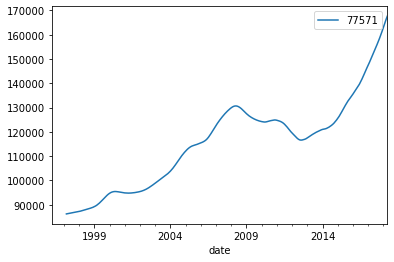

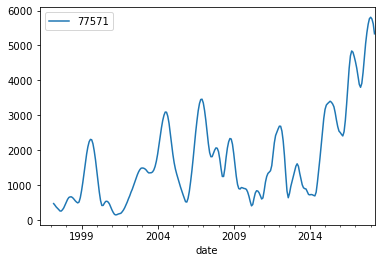

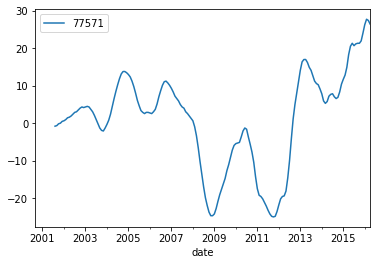

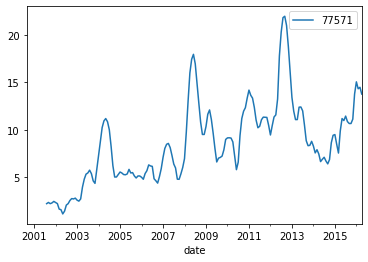

In [229]:
print(stationarity_check(df_77571))
print(stationarity_check(rm_diff_2.dropna()))

In [230]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1893.027
Date:                Wed, 06 Oct 2021   AIC                           3792.054
Time:                        14:31:23   BIC                           3802.793
Sample:                    04-01-1996   HQIC                          3796.369
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1636.3189   3109.209      0.526      0.599   -4457.620    7730.257
ar.L1          0.9947      0.007    143.037      0.000       0.981       1.008
sigma2      9.217e+04   7546.305     12.214      0.0

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  war

In [231]:
y_train_hat = sm.predict()
y_train_hat

1996-04-01    111897.937948
1996-05-01     85505.226855
1996-06-01     85605.207055
1996-07-01     85805.167454
1996-08-01     85905.147654
                  ...      
2015-12-01    137194.990131
2016-01-01    138294.772328
2016-02-01    139694.495125
2016-03-01    140594.316923
2016-04-01    141194.198121
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [235]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, y_train_hat, squared=False)
rmse

1781.8310247517156

In [236]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(train, order=[1,0,0]).fit()
sarimax.summary()

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77571   No. Observations:                  241
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1860.654
Date:                Wed, 06 Oct 2021   AIC                           3725.309
Time:                        14:35:53   BIC                           3732.278
Sample:                    04-01-1996   HQIC                          3728.117
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.73e-05   1.29e+04      0.000       1.000       1.000
sigma2      2.838e+05   2.48e-14   1.14e+19      0.000    2.84e+05    2.84e+05
===================================================================================
Ljung-Box (L1) (Q):                 192.78   Jarque-Bera (JB):                12.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.55   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [237]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, y_train_hat, squared=False)
rmse

1781.8310247517156

In [238]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [239]:
def plot_predictions(test=test, sarimax=sarimax):
    
    '''
    Pass a test set, as well as a model fit to the training set 
    to this function, and plot the test predictions against
    the true test values
    '''
    
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


6224.873068100134
6003.230271519471


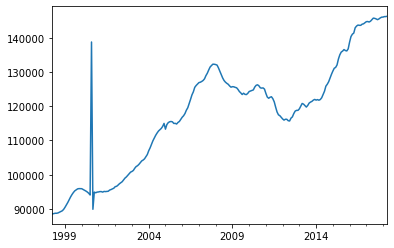

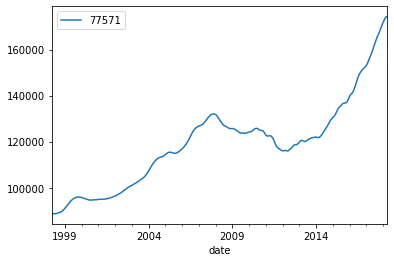

In [240]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)

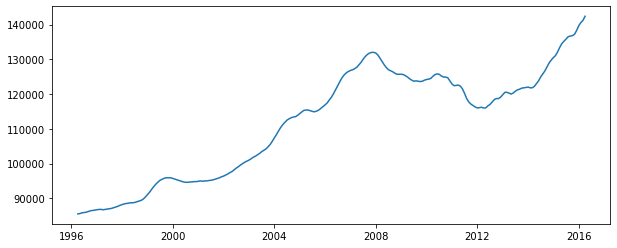

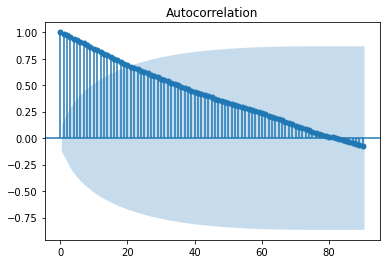

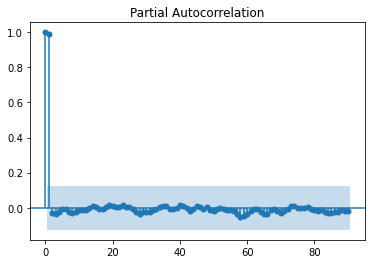

In [241]:
plt.figure(figsize=(10, 4))

plt.plot(train)
plt.show()
plot_acf(train, lags=90) 
plt.show()
plot_pacf(train, lags=90) 
plt.show()

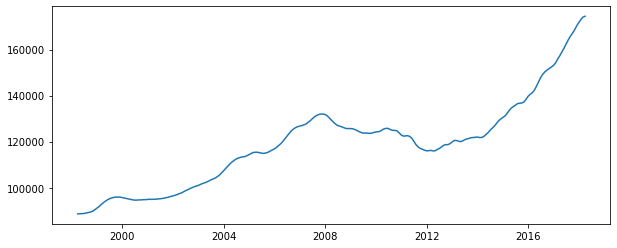

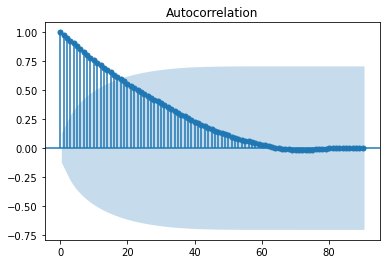

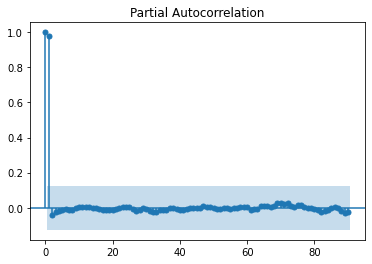

In [242]:
plt.figure(figsize=(10, 4))

plt.plot(test)
plt.show()
plot_acf(test, lags=90) 
plt.show()
plot_pacf(test, lags=90) 
plt.show()

In [151]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()
print(tscv)

for train, test in tscv.split(X):
    print(train, test)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
[0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19 20 21 22 23 24 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] [26 27 28 29 30 31 32 33]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] [34 35 36 37 38 39 40 41]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41] [42 43 44 45 46 47 48 49]


In [176]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df_log_wrm, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  265
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1893.027
Date:                Wed, 06 Oct 2021   AIC                           3792.054
Time:                        14:02:23   BIC                           3802.793
Sample:                    04-01-1996   HQIC                          3796.369
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1636.3189   3109.209      0.526      0.599   -4457.620    7730.257
ar.L1          0.9947      0.007    143.037      0.000       0.981       1.008
sigma2      9.217e+04   7546.305     12.214      0.0

/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/rashidkarriti/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
